In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
from decode_fish.engine.microscope import add_pos_noise
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.matching import *
from decode_fish.funcs.predict import window_predict
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from decode_fish.funcs.routines import *
from decode_fish.engine.point_process import *

from omegaconf import open_dict
from hydra import compose, initialize

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training (data taken from starfish MERFISH analysis notebook)
https://spacetx-starfish.readthedocs.io/en/mcai-notebooks-sphinxgallery/gallery/pipelines/merfish_pipeline.html

Load base config. train.yaml contains all hyperparameters, merfish_starfish contains dataset specific information (e.g. number of channels, number of genes, dataset location etc.) that stay fixed across experiments.

In [48]:
initialize(config_path="config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [259]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_starfish"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

<details><summary>Notes on the MERFISH generative model: **click to expand!** </summary>
    
The basic observation model is given by:
$$Y=DXG+b+\epsilon$$
where Y is the observed multi-channel data, D is the codebook, X is the distribution of transcripts (i.e. the target), G is the PSF and b is additive baseline activity.

Going into more detail these are some additional properties that could be accounted for:
    
1) The data is usually recorded in multiple color channels (here 2, 2 color channels * 8 rounds = 16 bits)
   * This introduces chromatic aberration between the two sets of channels
   * PSFs might be different too
   * We learn separate PSFs (genm.PSF.ncols) as well as chromatic aberration (training.mic.par_grads.color_shifts). 
    
2) There might be small spatial shifts between the color channels (even after alignment during preprocessing)
   * We learn these shifts (training.mic.par_grads.channel_shifts)
    
3) Scaling between channels and colors can vary widely and normalizing it is crucial for performance
   * We can either try to equalize intensities in preprocessing or learn them (training.mic.par_grads.channel_facs)
    
4) As noted in the [supplement](https://www.pnas.org/doi/10.1073/pnas.1612826113) "spot centroids for the same RNA varied in position by ∼100 nm in different imaging rounds, possibly because of the finite cellular volume occupied by each RNA"
   * During simulation we randomly shift the positions across channels for each transcript (genm.microscope.pos_noise_xy / pos_noise_z)
    
5) Just looking at the data we often observe spots that are only visible in single channels and can therefore not be attributed to any code.
   * We simulate such spurious spots with genm.emitter_noise
    
6) At transcription sites we might observe very high local densities of transcripts. (Though these seemed more relevant for smFISH data than for MERFISH?)
   * We simulate such local clusters with the settings in genm.foci. 
    
</details>

In [267]:
# project and run_name set the directories where the trained models are saved, as well as the structure in wandb.ai
cfg.output.project = 'MERFISH_starfish'
cfg.run_name ='MERFISH_sweep_gen_11'
cfg.output.group='MERFISH_sweep_gen_11'

cfg.data_path.image_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/thetascaled_stack.tiff'

'''Simulation parameters'''
# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]                       
    
# Sets the emitter density (range of uniform probabilities for a voxel to contain a transcript)
cfg.genm.prob_generator.low = 0.05
cfg.genm.prob_generator.high = 0.15

# Sets the intensity distribution of the simulation (parametrizes of a gamma distribution)
cfg.genm.intensity_dist.int_conc = 3.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

# Multiplicative overall scaling. Should be adjusted to match the oberved intensity values
cfg.genm.microscope.scale = 800
cfg.genm.PSF.mode = 'bicubic'
cfg.genm.microscope.norm = 'escort'

# Background values are sampled by smoothing the real data
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.roi_mask.percentile = 30

# In addition to real emitters that are sampled from the codebook (and are visible in multiple channels) we sample spurious 'fake' emitters that only show up in a single channel (to make the network more robust)
cfg.genm.emitter_noise.rate_fac = 3.

# Noise on the coordinates of individual transcripts across channels
cfg.genm.pos_noise.pos_noise_z = 0.04
cfg.genm.pos_noise.pos_noise_xy = 0.3

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MFsf_psf1n.tif'

cfg.genm.noise.theta = 0.1
cfg.genm.exp_type.randomize_noise_range = [0.3, 3.]
    
'''Performance tracking'''

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'
cfg.output.log_interval = 500
cfg.evaluation.code_stats.enabled = True

'''Network architecture'''
cfg.network._target_ = 'decode_fish.engine.model.UnetDecodeNoBn_2S'
cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.network.n_chrom_map_ch = 2
cfg.genm.microscope.col_shifts_enabled = True

'''Training'''
cfg.training.bs = 20
cfg.training.net.opt.lr = 5e-4

cfg.training.schedule = [10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 10000]
cfg.training.num_iters = 44000

cfg.training.mic.sched.step_size = 2000
cfg.training.psf.sched.step_size = 2000
cfg.training.mic.mean_diff = True

cfg.training.psf.opt.lr = 0.0002
cfg.training.mic.opt.lr = 0.001
cfg.training.psf.l1_reg = 0.0
cfg.genm.exp_type.const_theta_sim = True

cfg.genm.phasing = 0.1

cfg.training.net.bl_loss_scale = .003

cfg.sim.bg_estimation.shuffle_ch = True
cfg.genm.exp_type.em_noise_inf = True

cfg.data_path.model_init = None
cfg.training.target_mean = True
cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/2Sx/checkpoint/'
cfg.data_path.micro_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/2Sx/checkpoint/'

# Which parts of the model to train
cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = True
cfg.training.mic.par_grads.color_shifts = True
cfg.training.mic.par_grads.z_facs = False
cfg.training.mic.par_grads.sc_fac = True

In [268]:
cfg.training.mic.par_grads.color_shifts = False
name = 'no_col_shifts'

Save cfg

In [269]:
fname = f'config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_sweep_gen_11'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training with a bigger batch size you could execute:  
"python decode_fish/train.py +experiment=MERFISH_sweep_gen_1 training.bs=50 run_name=bs_50"


In [270]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name={name} output.group={cfg.run_name}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_sweep_gen_11 run_name=no_col_shifts output.group=MERFISH_sweep_gen_11


Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  

In [185]:
img_5d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Estimate noise scale

This function allows you to visually compare the recorded data and the simulations generated with the given config.  

In [186]:
import tifffile
thetas = np.zeros(img_5d.shape[:2])
vol_mean = img_5d.mean()

for i in tqdm(range(len(img_5d))):
    mask = 1 - get_roi_mask(img_5d[i], pool_size=(10,10,10), percentile=50)
    for c in range(img_5d.shape[1]):

        bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img_5d[i][c,:,:,:].to('cuda'))
        theta = estimate_noise_scale(img_5d[i][c][mask.nonzero()], bg_est[mask.nonzero()], percentile=98, plot=False)
        thetas[i,c] = theta
        
ch_facs = 1/thetas.mean(0)
scaled_vol = img_5d * ch_facs[:,None,None,None]
scaled_vol *= vol_mean/scaled_vol.mean()
# tifffile.imsave('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/thetascaled_stack.tiff', data=np.array(scaled_vol, dtype=np.float32))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it]


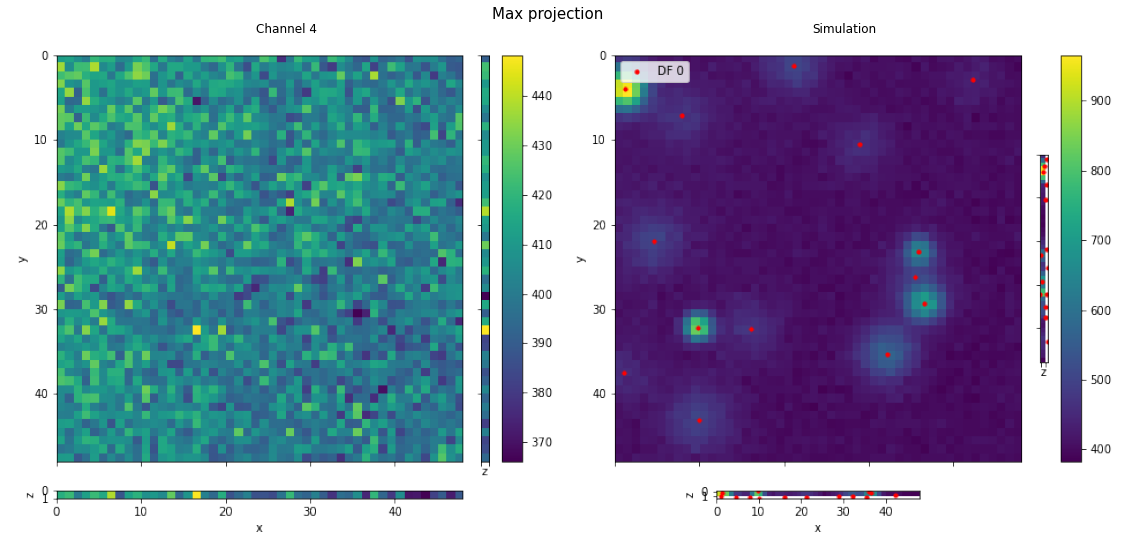

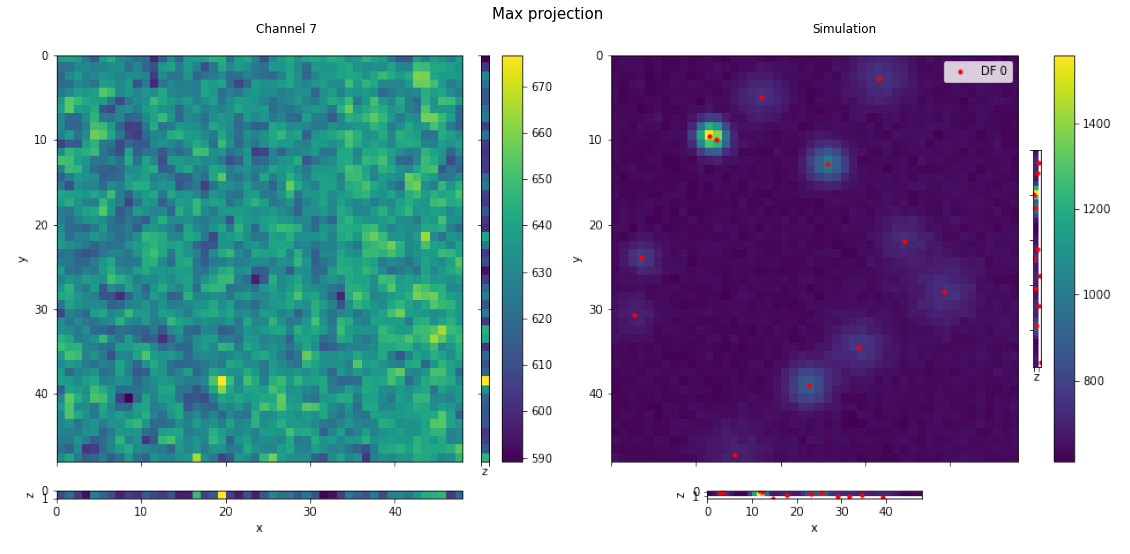

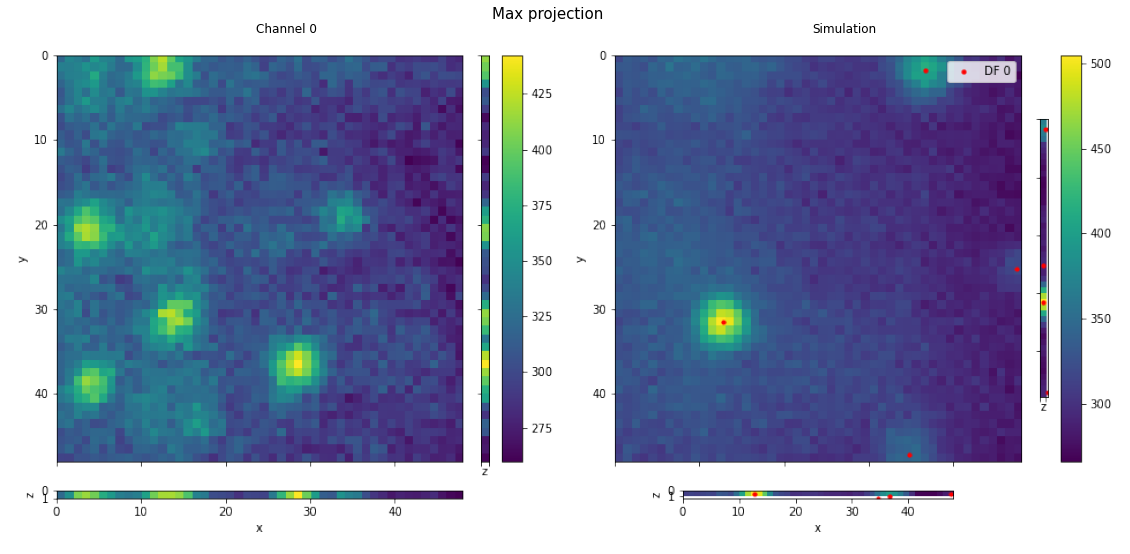

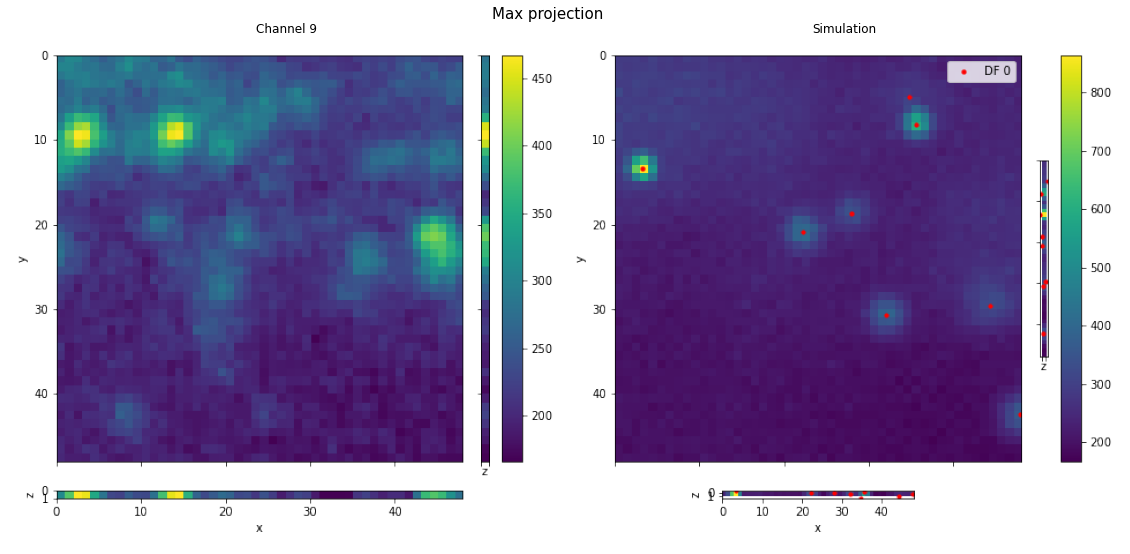

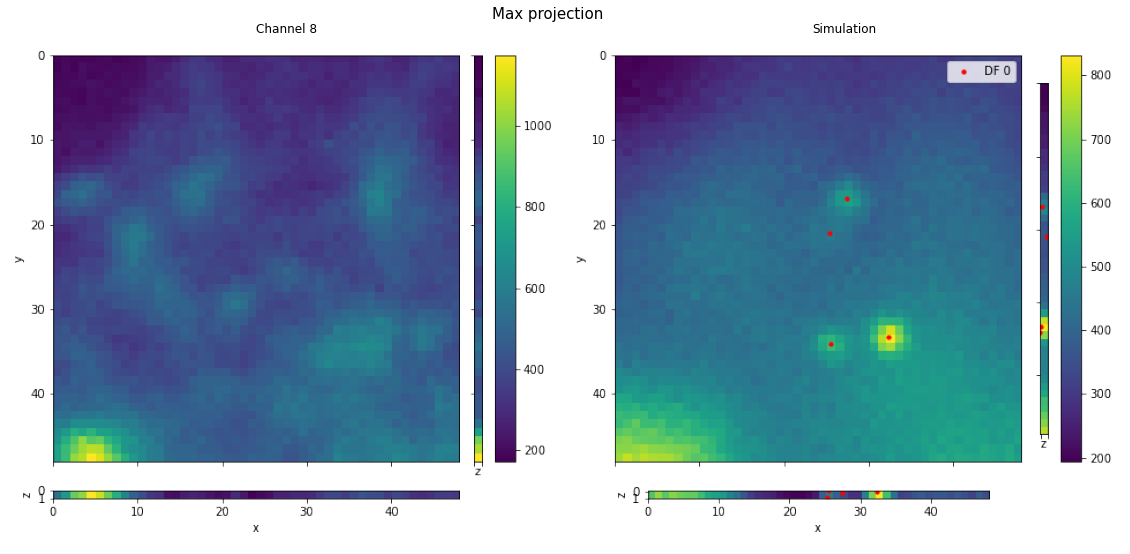

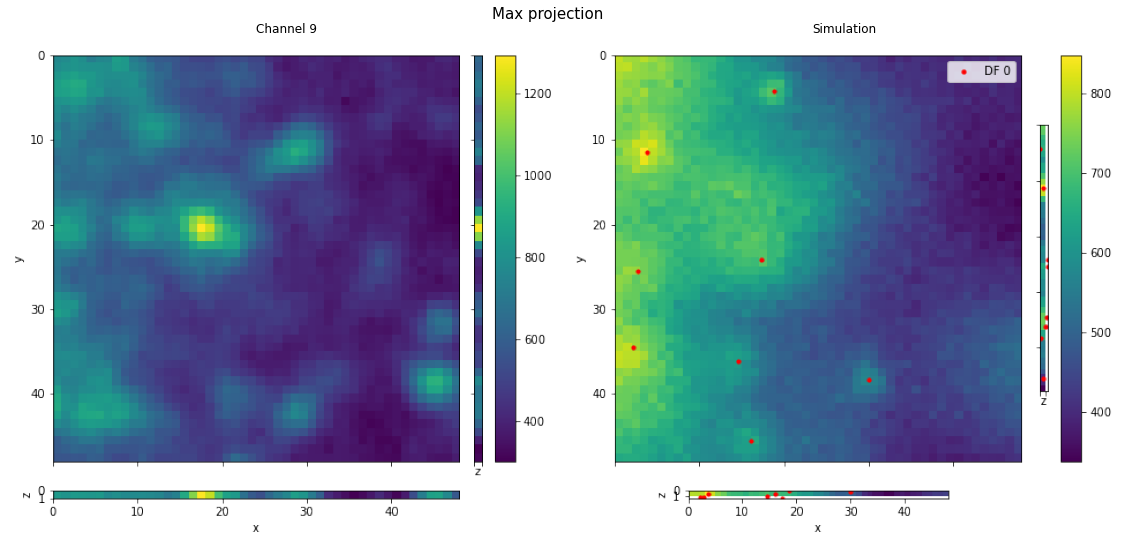

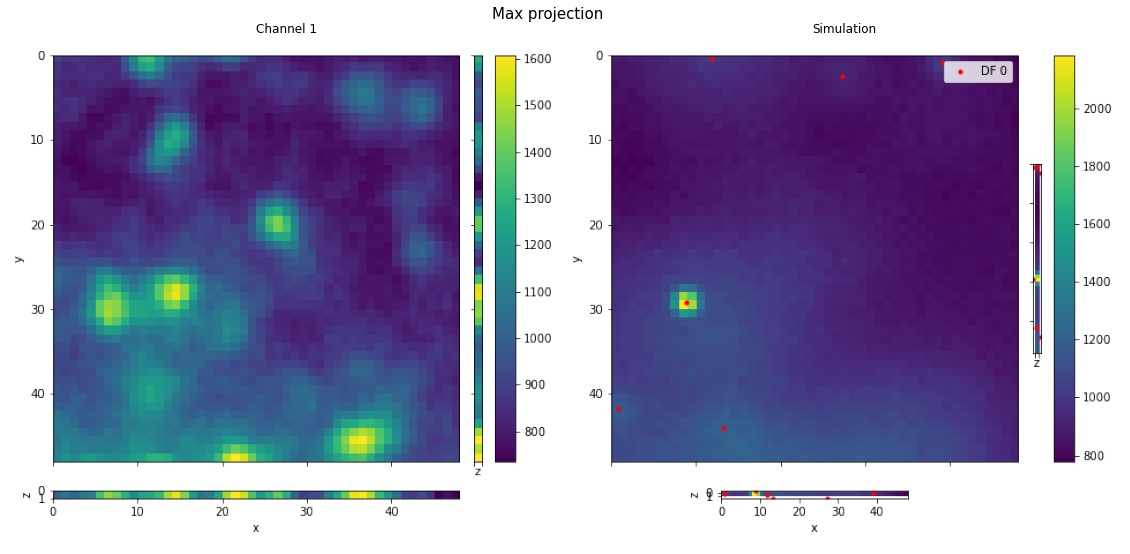

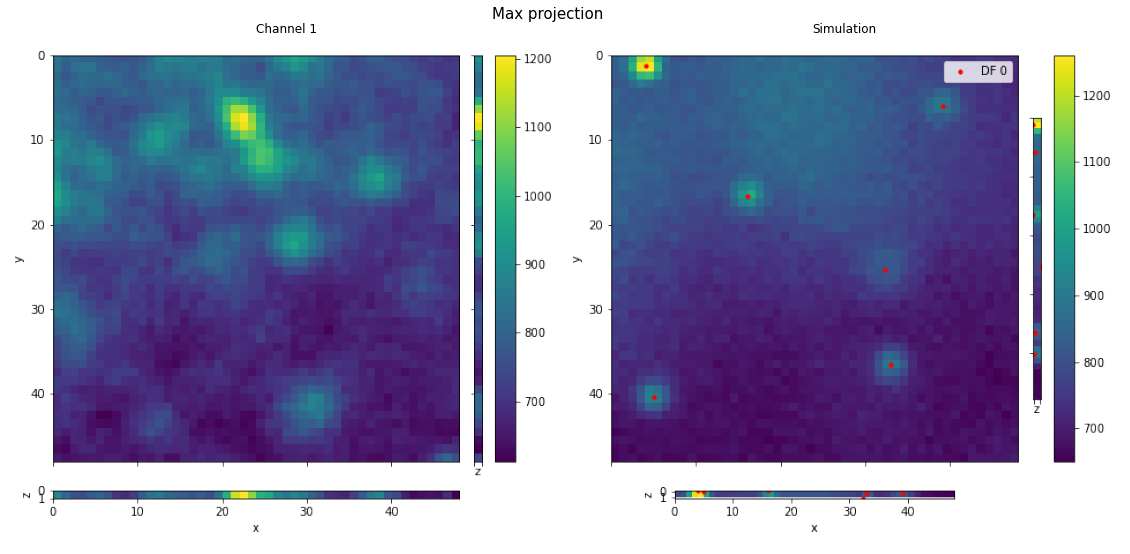

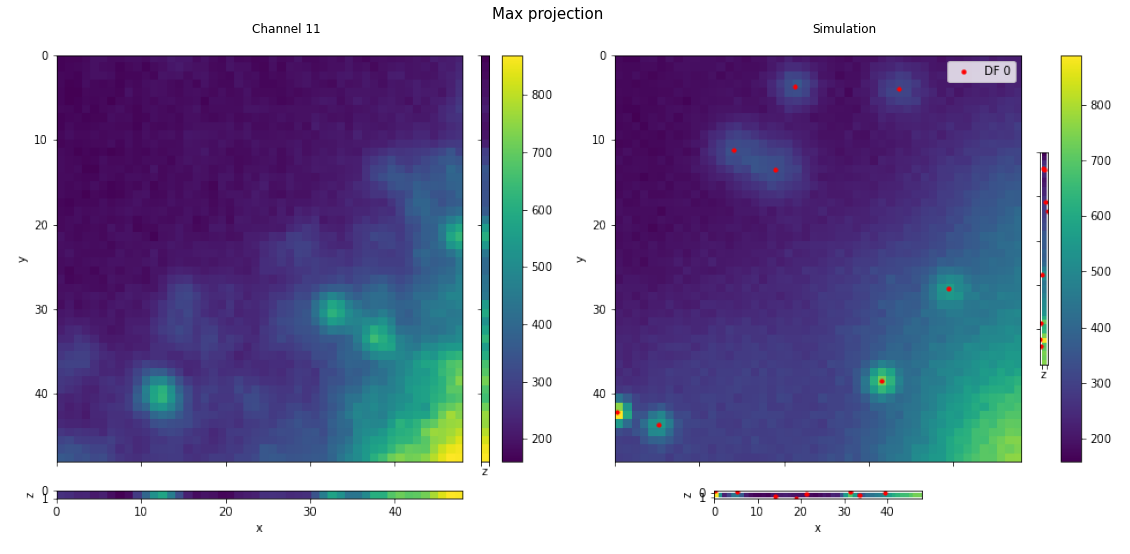

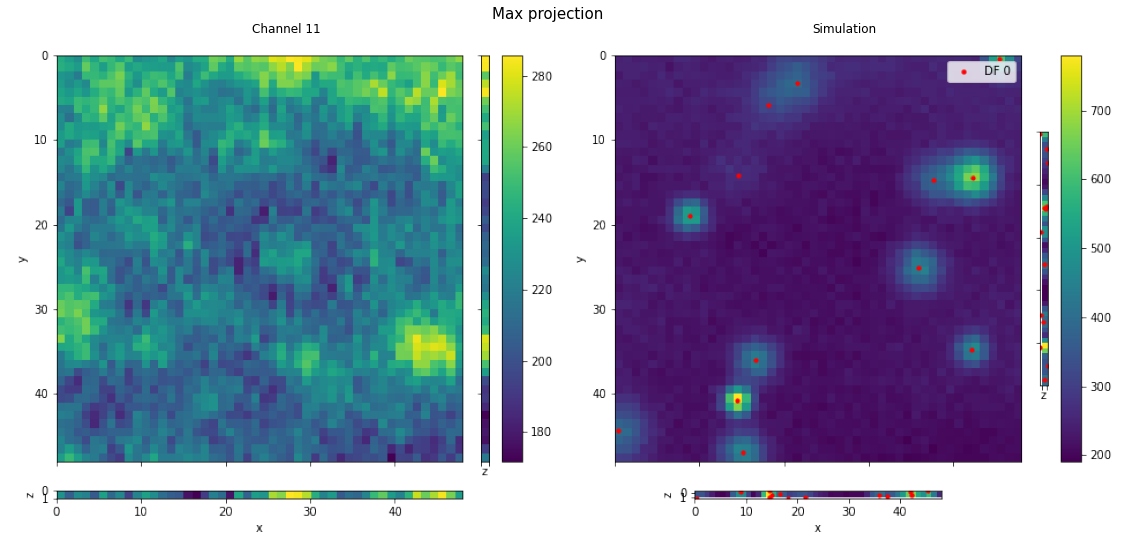

In [170]:
point_process = PointProcessUniform(**cfg.genm.intensity_dist, n_channels=cfg.genm.exp_type.n_channels, sim_z=True, slice_rec=True, codebook=None, int_option=1)
get_simulation_statistics(decode_dl, micro, point_process, int_threshold=0.1, samples=10)

# Evaluation

In [255]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/no_col_shifts//train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_3/norm:escortxlr:0.0001/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_4/high:0.1/train.yaml')

In [176]:
codebook, targets = get_starfish_codebook()

In [177]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(load_tiff_image(cfg.data_path.psf_path))
post_proc.codebook = torch.tensor(codebook)
if cfg.genm.exp_type.em_noise_inf: post_proc.codebook = torch.tensor(expand_codebook(torch.tensor(codebook)))

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Parameter containing:
tensor([0.7599], device='cuda:0', requires_grad=True)


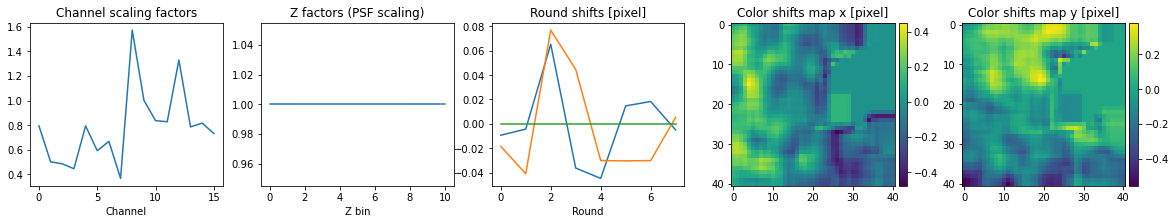

In [179]:
print(micro.sc_fac)
plot_micro_pars(micro)

Plot mean projections of the PSF before and after optimizing it during training

In [180]:
# Normalize
# Detection efficiency vs z. 
# limit z range depending on data
# add noise emitter channels 
# 16 channels RGB kodieren

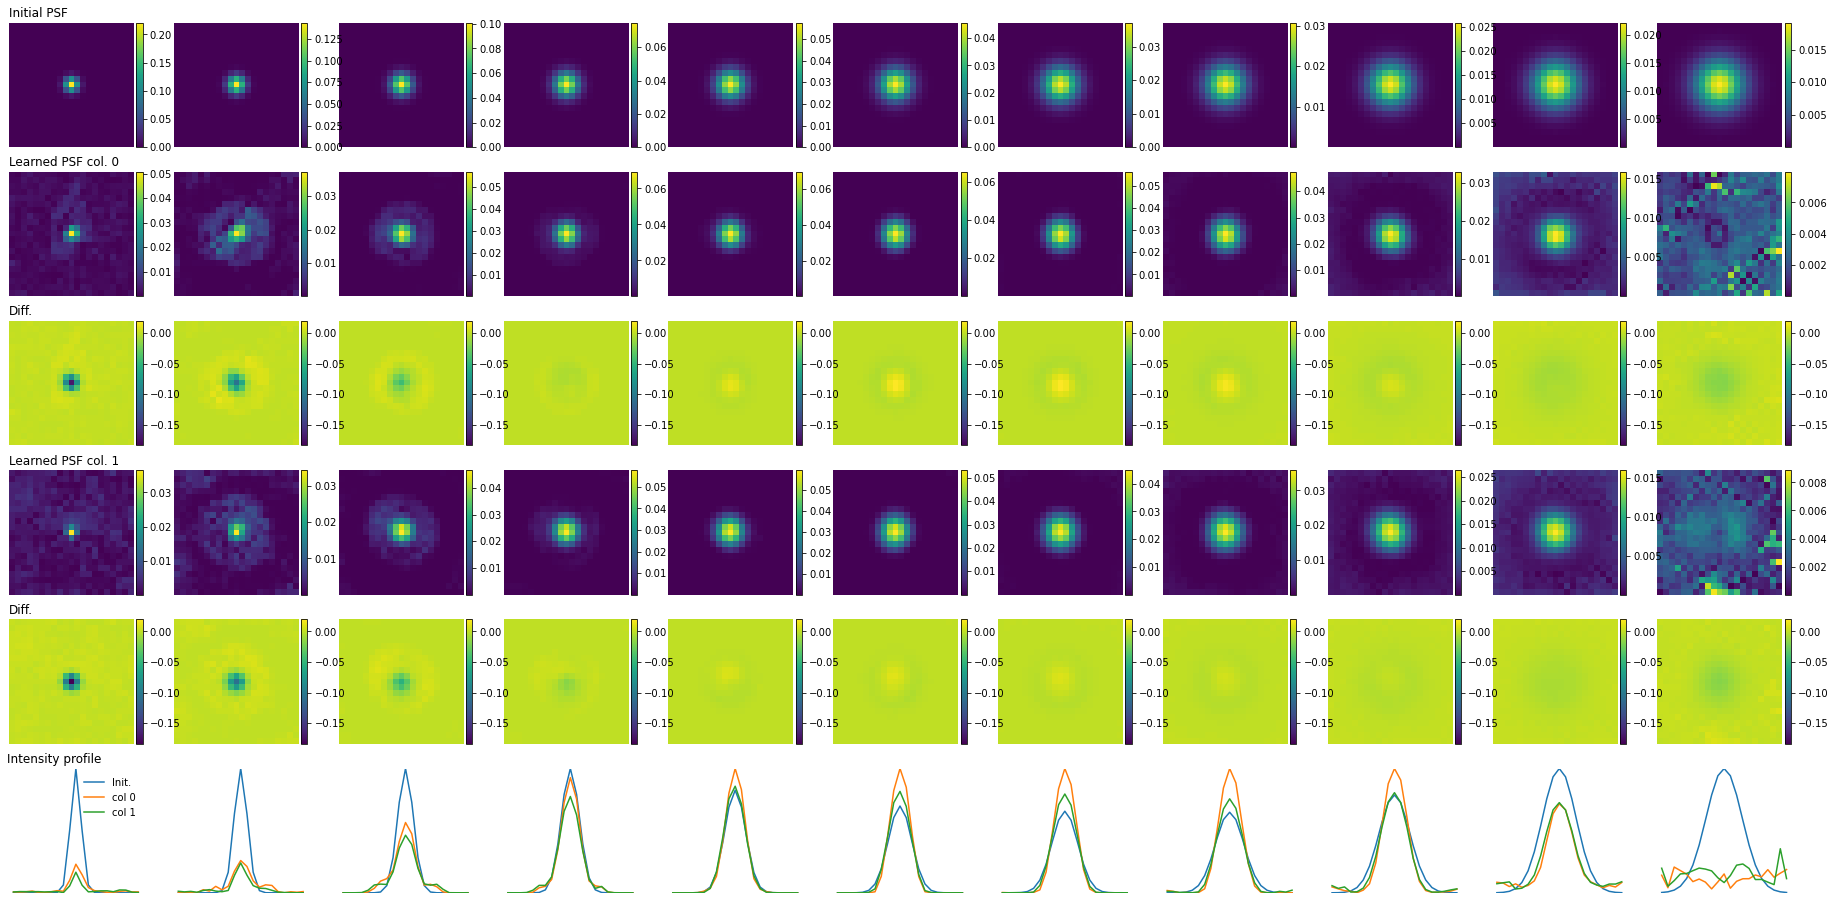

In [181]:
plot_slice_psf_pars(psf_vol, psf_init[None], normed=True)

Sample random sub volumes and overlay them with predictions,  also shows the reconstruction from applying the microscope and PSF model to those predictions.

5


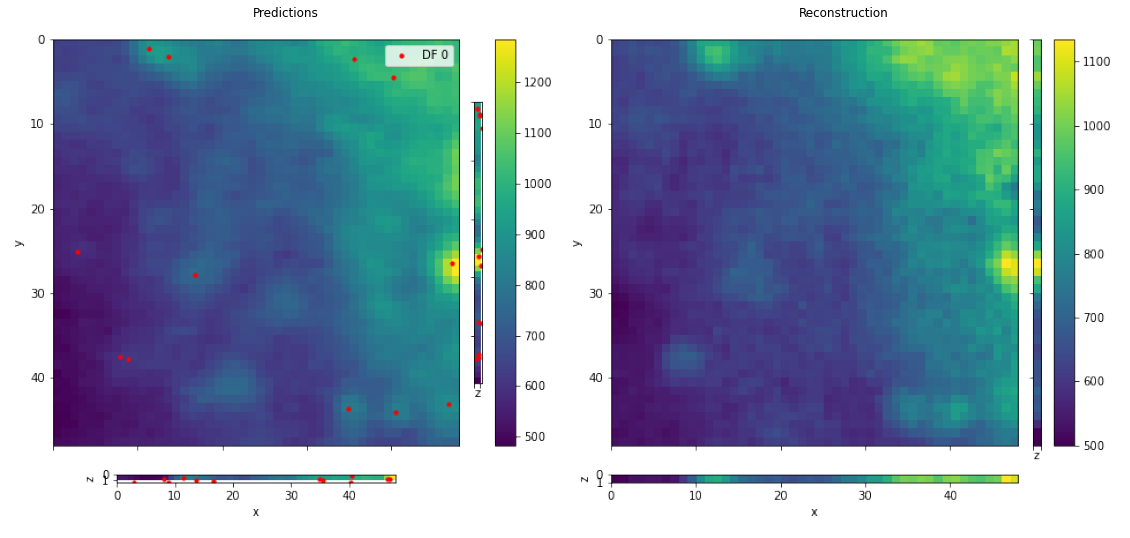

In [182]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)

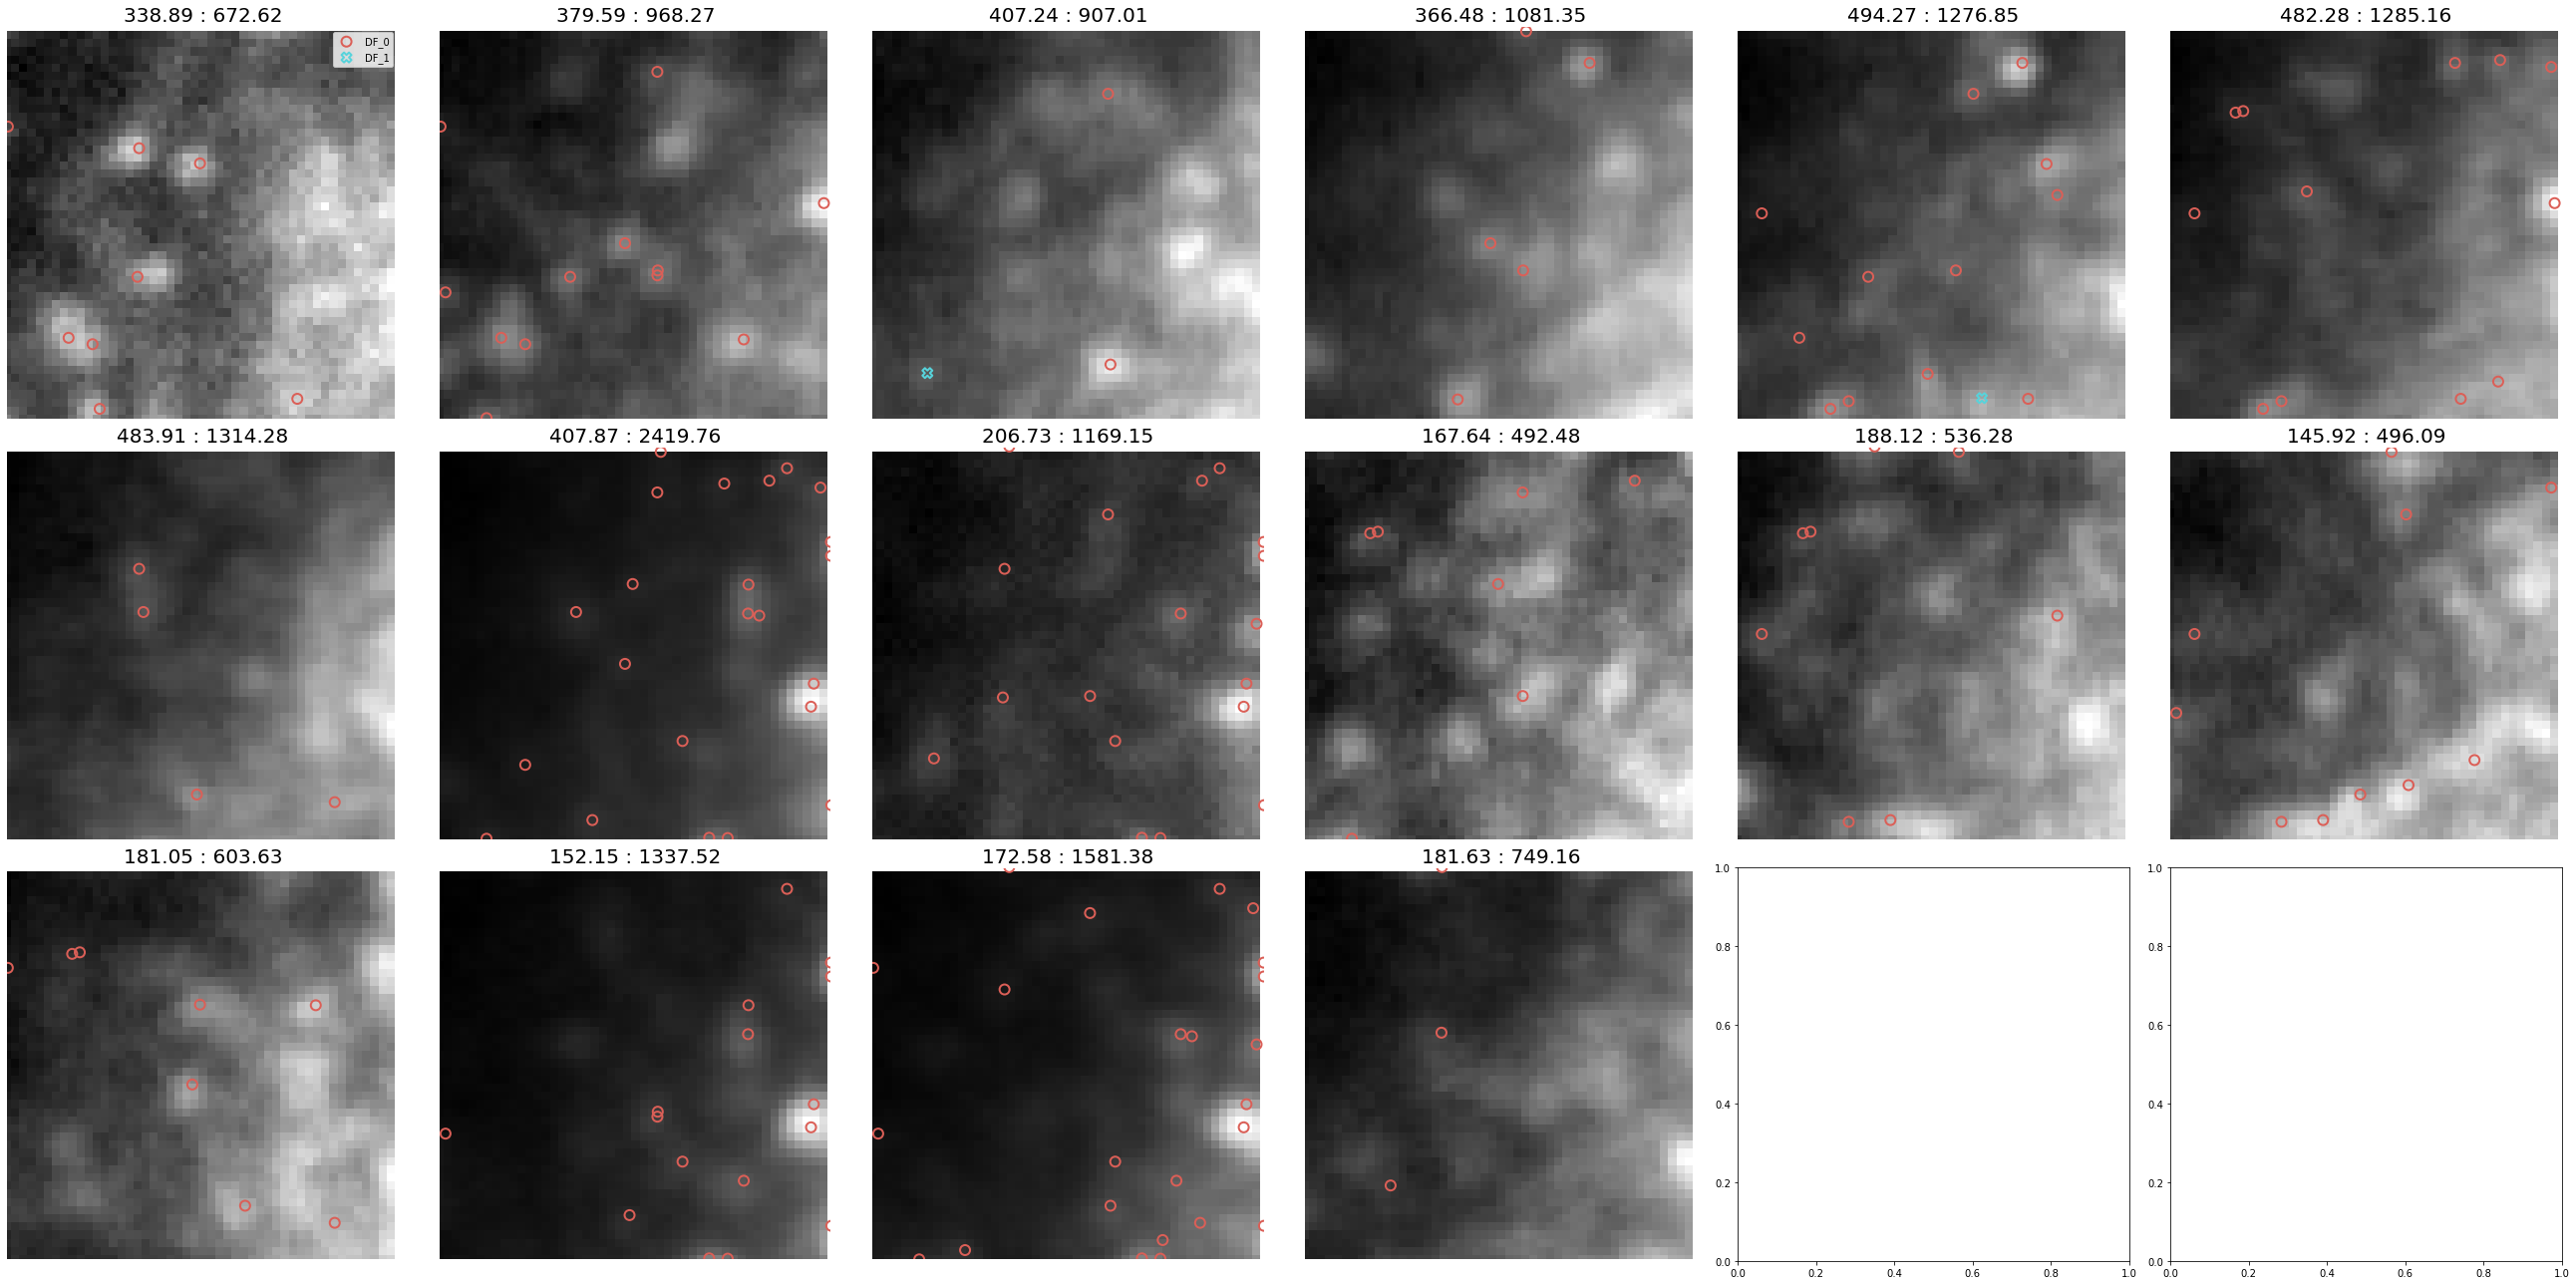

In [183]:
_ = plot_channels(x, dfs=[pred_df[pred_df['code_inds']<len(codebook)], pred_df[pred_df['code_inds']>len(codebook)]], n_rows=3, codebook=post_proc.codebook,sc_sz=100)

In [188]:
code_weight = torch.ones(len(post_proc.codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc, 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                    codebook=post_proc.codebook, int_option=cfg.training.int_option, code_weight=code_weight)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


In [192]:
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, point_process, 20, n_codes=len(codebook), rate_fac=1., pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z)

In [193]:
pred_dfs = []
net_inp = torch.concat([xsim,cols], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [194]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.586
Precision: 0.958
Jaccard: 57.172
RMSE_vol: 59.457
Eff_3d: 47.866
FN: 38051.0 FP: 2341.0
Num. matches: 53921.000
Shift: 0.17,-0.34,1.14


If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

### Real data inference

In [205]:
res_df = window_predict(model, post_proc, decode_dl.dataset.volumes, window_size=[None, 256, 256], device='cuda', chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult())
res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

torch.Size([1, 16, 1, 2048, 2048])


In [206]:
all_df = res_df.copy()
sel = res_df['code_inds']<len(codebook)
print(sum(sel), len(res_df)/sum(sel))
res_df = res_df[sel]

26015 1.1702479338842975


In [208]:
from decode_fish.funcs.merfish_eval import *
bench_df = get_starfish_benchmark()
# bench_df = bench_df[bench_df['gene'] != 'MALAT1']
bench_df['class'] = bench_df['gene'].str.contains('Blank')

13832


In [209]:
ist_df = get_istdeco()
# ist_df = ist_df[ist_df['gene'] != 'MALAT1']
ist_df['class'] = ist_df['gene'].str.contains('Blank')
ist_df['x'] += 150
ist_df['y'] += 150

156501


In [210]:
res_df['gene'] = targets[res_df['code_inds']]
res_df['class'] = res_df['gene'].str.contains('Blank')
# res_df = res_df[res_df['gene'] != 'MALAT1'] 
res_df['x'] += 100
res_df['y'] += 100

In [168]:
# Filter out xy across frames (because same emitter could be in two adjacent slices)
# Different PSFs for different slices? (oil objective makes PSF dependent on)

In [169]:
res_single = remove_doublets(res_df, tolerance=200)
print(len(res_single)/len(res_df))
# res_single['int_ratio'] = sel_int_ch(res_single, codebook)['int_ratio']
# X = np.concatenate([res_single[keys].values])
# res_single['score'] = clf.predict_proba(X)[:,1]

0.9502823086574655


/tmp/ipykernel_53387/1818027843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_single['int_ratio'] = sel_int_ch(res_single, codebook)['int_ratio']


In [170]:
# from decode_fish.funcs.merfish_codenet import code_net, conv_net, input_from_df
# # res_single.to_csv('data/qual_nets/starfish_test.csv')
# met_net = torch.load('data/qual_nets/net1.pkz')
# res_single['net_score'] = torch.sigmoid(met_net(input_from_df(res_single, codebook)).detach().cpu())
res_single = sel_int_ch(res_single, codebook)

(0.0, 100.0)

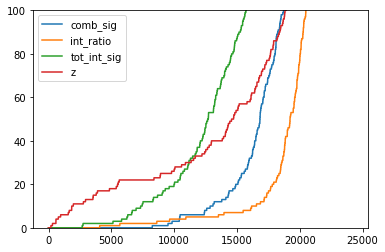

In [213]:
for k in ['comb_sig','int_ratio', 'tot_int_sig','z', 'net_score']:
    if k in res_single:
        r  = make_roc(res_single, k, ascending=True)
        plt.plot(r, label=k)

plt.legend()
plt.ylim(0,100)

In [72]:
dec_df15 = res_single.nsmallest(15000, 'int_ratio')
ist_df15 = ist_df.nlargest(15000, 'quality')
_, matches, _ = matching(ist_df15, dec_df15)

Recall: 0.709
Precision: 0.709
Jaccard: 54.975
RMSE_vol: 132.158
Eff_3d: 20.039
FN: 4358.0 FP: 4358.0
Num. matches: 10642.000
Shift: 2.29,0.28,-12.06


In [73]:
tps = dec_df15.loc[dec_df15['loc_idx'].isin(matches['loc_idx_pred'])]
fp_dec = dec_df15.loc[~dec_df15['loc_idx'].isin(matches['loc_idx_pred'])]
fp_b = ist_df15.loc[~ist_df15['loc_idx'].isin(matches['loc_idx_tar'])]
print(f'Matched: {len(tps)}', np.round(tps['gene'].str.contains('Blank').sum(),2))
print(f'Pred by DECODE but not Benchmark {len(fp_dec)}: ', np.round(fp_dec['gene'].str.contains('Blank').sum()))
print(f'Pred by Benchmark but not DECODE: {len(fp_b)}', np.round(fp_b['gene'].str.contains('Blank').sum()))

Matched: 10642 1
Pred by DECODE but not Benchmark 4358:  4
Pred by Benchmark but not DECODE: 4358 15


13832 13382


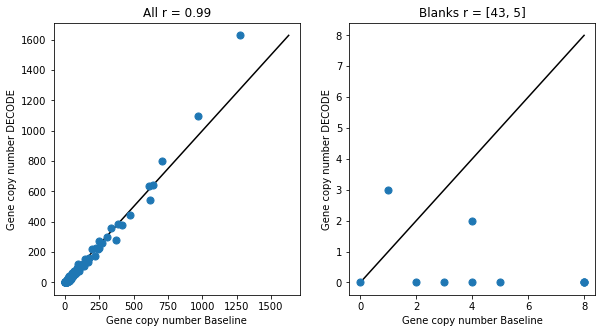

In [172]:
plot_gene_panels(res_single.nsmallest(13382, 'int_ratio'), bench_df, targets)

13832 19000


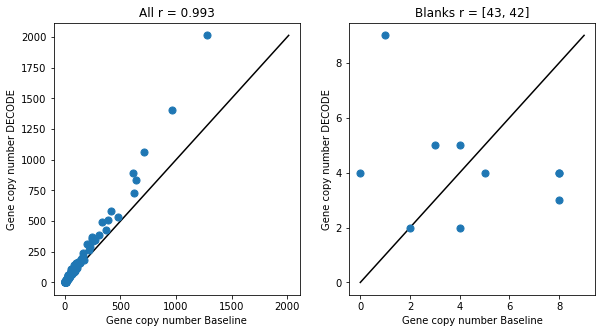

In [215]:
plot_gene_panels(res_single.nsmallest(19000, 'int_ratio'), bench_df, targets)

13832 13382


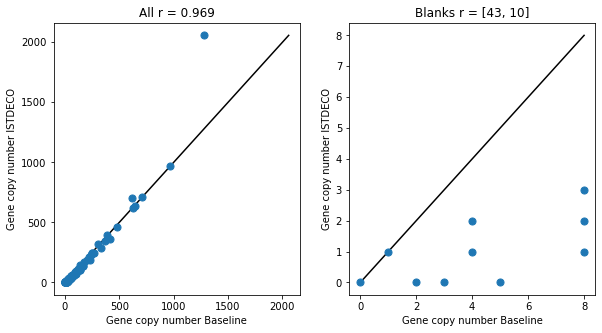

In [33]:
plot_gene_panels(ist_df.nlargest(13382, 'quality'), bench_df, targets, algo2='ISTDECO')

13832 17230


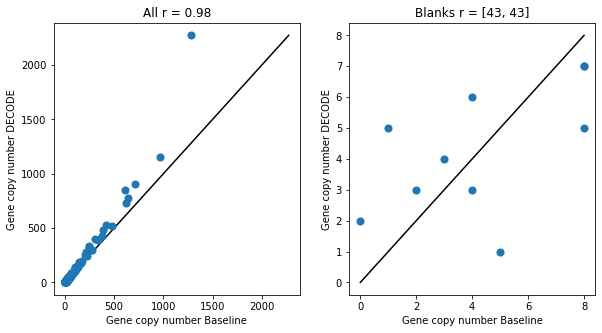

In [34]:
plot_gene_panels(ist_df.nlargest(17230, 'quality'), bench_df, targets)

(0.0, 22000.0)

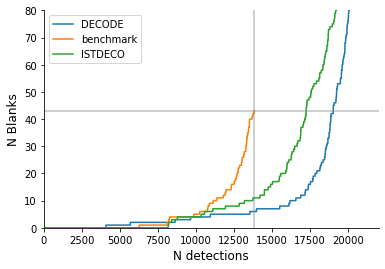

In [216]:
import seaborn as sns

r  = make_roc(res_single, 'int_ratio', ascending=True)
plt.plot(r, label='DECODE')
r  = make_roc(bench_df, 'total_magnitude', ascending=False)
plt.plot(r, label='benchmark')
r  = make_roc(ist_df, 'quality', ascending=False)
plt.plot(r, label='ISTDECO')
plt.legend()
plt.ylim(0,80)
sns.despine()

plt.plot([0,22000],[bench_df['class'].sum(),bench_df['class'].sum()], color='gray', alpha=0.5)
plt.plot([len(bench_df),len(bench_df)],[0,80], color='gray', alpha=0.5)

plt.xlabel('N detections', size=12)
plt.ylabel('N Blanks', size=12)
plt.xlim(0,22000)

24236


(600.0, 750.0)

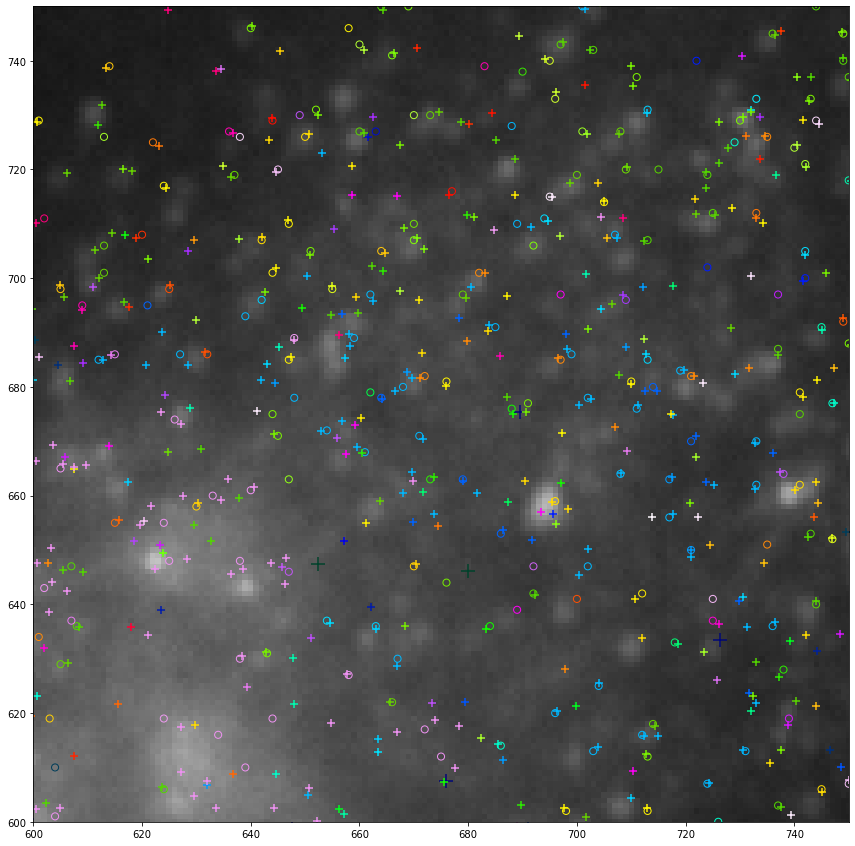

In [219]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

ind = 0
img = load_tiff_image(cfg.data_path.image_path)
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(bench_df)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

## Compare distribution of metrics for blanks

KeyError: 'net_score'

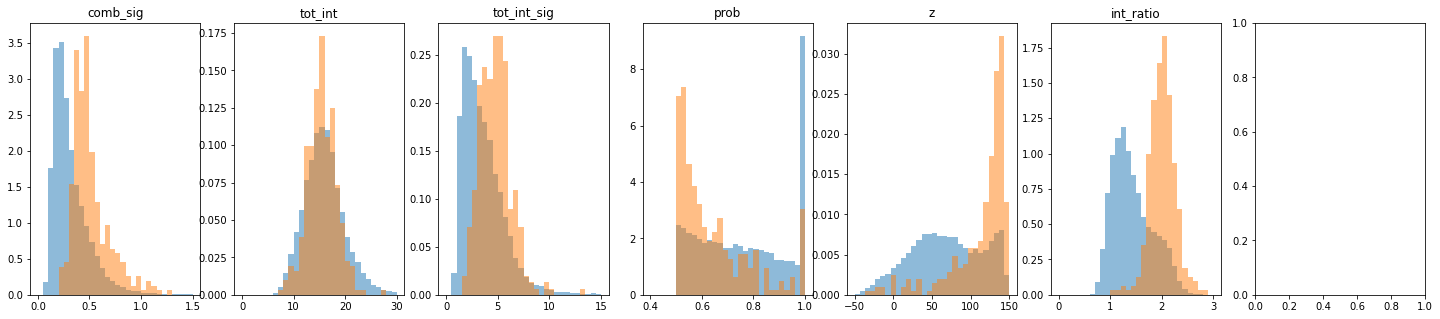

In [220]:
# res_single = sel_int_ch(res_single, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31), np.linspace(0.,1., 31)]
plt.figure(figsize=(25,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [221]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.3711578614601652
0 2 0.399603417163809
0 3 0.34311134022318857
1 2 0.33179995818163593
1 3 0.29046589473662404
2 3 0.35228456072763054


## Compare distribution of real data and simulated data predictions

In [227]:
res_single = remove_doublets(res_df, tolerance=200)
res_single = sel_int_ch(res_single,codebook)

In [223]:
code_df = sel_int_ch(code_df,codebook)

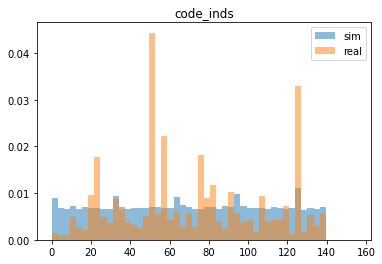

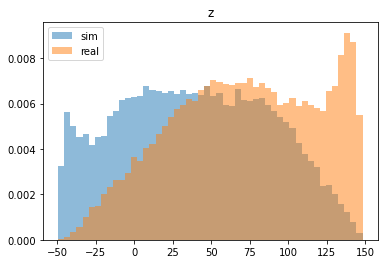

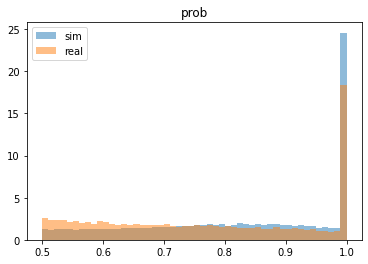

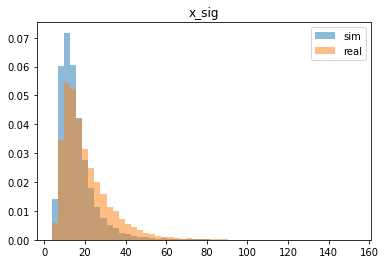

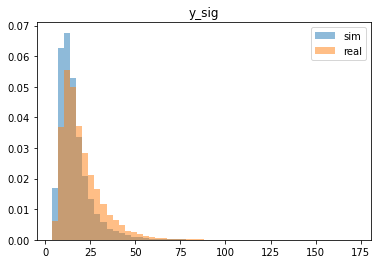

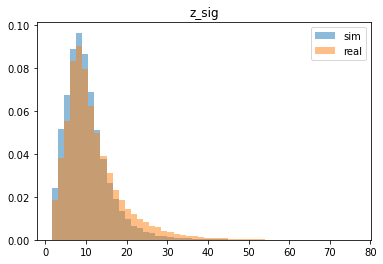

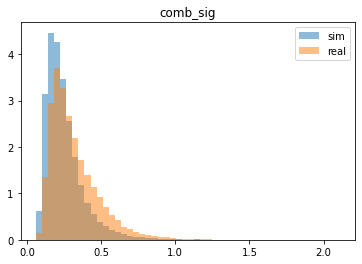

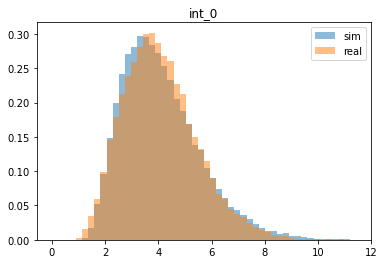

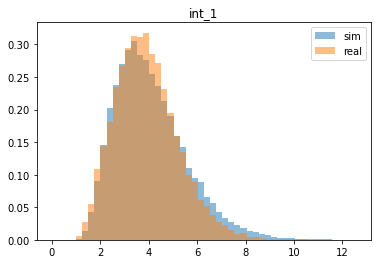

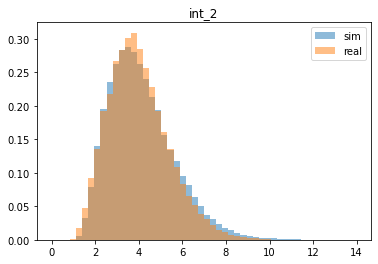

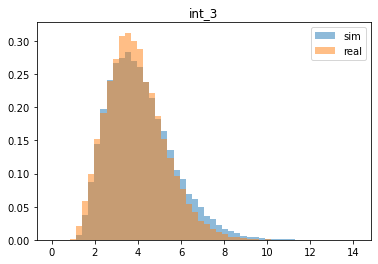

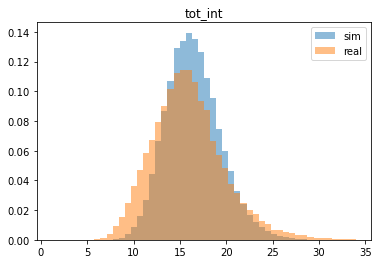

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


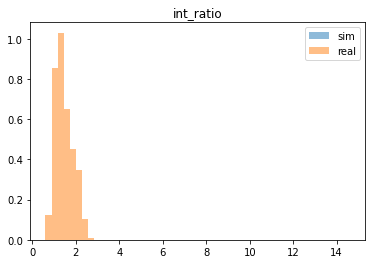

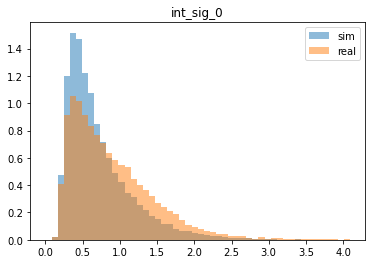

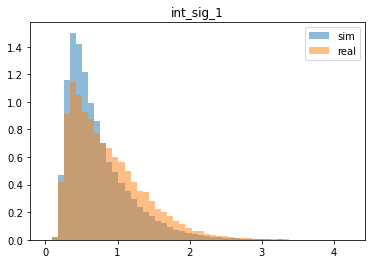

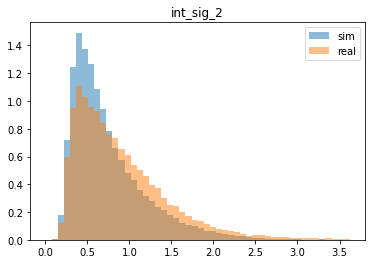

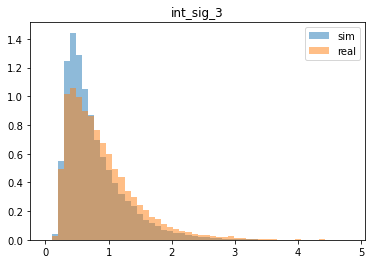

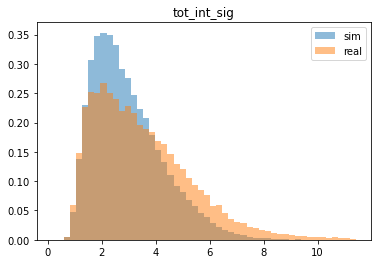

In [228]:
# tra = sel_int_ch(pred_df, codebook)
for k in res_single.keys():
    if k not in ['loc_idx','frame_idx','class','gene','score','x','y']:
        if k in code_df and k in res_single:
            bins = np.linspace(pred_df[k].min(), pred_df[k].max(), 51)
            plt.hist(code_df[k], alpha=0.5, bins=bins, density=True, label='sim')
            plt.hist(res_single[k], alpha=0.5, bins=bins, density=True, label='real')
            plt.title(k)
            plt.legend()
            plt.show()

In [243]:
out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/starfish/MERFISH_sweep_gen_11/'
cfg_files = glob.glob(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/*/train.yaml')

for f in cfg_files:
    print(f)
    cfg = OmegaConf.load(f)
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
    
    res_df = window_predict(model, post_proc, decode_dl.dataset.volumes, window_size=[None, 256, 256], device='cuda', chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult())
    res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

    res_df.to_csv(f'{out_dir}/{cfg.run_name}.csv')

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/sl_no_learn/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/2Sx/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/l1_fix/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/no_psf_vol/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/no_col_shifts/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_11/no_ch_shifts/train.yaml


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
torch.Size([1, 16, 1, 2048, 2048])


In [250]:
res_files = glob.glob(f'{out_dir}/*.csv')
df_dict = {}

for f in res_files:
    name = f.split('/')[-1][:-4]
    res_df = pd.read_csv(f)
    all_df = res_df.copy()
    sel = res_df['code_inds']<len(codebook)
    print(sum(sel), len(res_df)/sum(sel))
    res_df = res_df[sel]

    res_df['gene'] = targets[res_df['code_inds']]
    res_df['class'] = res_df['gene'].str.contains('Blank')

    res_single = remove_doublets(res_df, tolerance=200)
    res_single = sel_int_ch(res_single, codebook)
    
    df_dict[name] = res_single

17649 1.1896991330953595
25637 1.1520848773257402
19050 1.1844619422572178
24297 1.15261143351031
26015 1.1702479338842975
25504 1.1672678795483062


(0.0, 100.0)

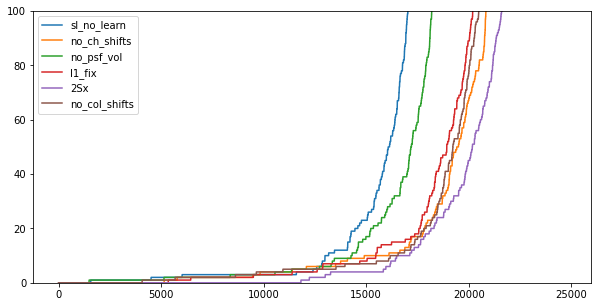

In [254]:
plt.figure(figsize=(10,5))
for n in df_dict:
    
    r  = make_roc(df_dict[n], 'int_ratio', ascending=True)
    plt.plot(r, label=n)

plt.legend()
plt.ylim(0,100)